In [22]:
import pandas as pd
import numpy as np
import urllib.request
import datetime
from os.path import join
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpltPath
from shapely.geometry import Polygon
from collections import Counter
from scipy.ndimage.filters import gaussian_filter
import scipy
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale = 2)

In [23]:
def hazard_cond_prob(obs, preds, A, B, n=2, lower_bin=None, upper_bin=None):
    """
    Args:
        obs: SPC Observations array
        preds: HWT mode predictions array
        A: SPC Hazard ('Torn', 'Hail', 'Wind')
        B: Condition - Storm Mode prediction ('Supercell', 'QLCS', 'Disorganized')
    Returns: Conditional probability: P(A|B)
    """
    if upper_bin is not None:
        arr = xr.DataArray(np.where((preds[f'{B}_SSPF'] >= lower_bin) & (preds[f'{B}_SSPF'] < upper_bin), 1, 0), dims=dict(time='time', y='y', x='x'))
        hits = np.where((arr >= 1) & (obs[A] >= 1), arr, 0).sum()
        mode_bin = np.where(arr >= 1, arr, 0).sum()
    else:    
        hits = np.where((preds[f'{B}_{n}%'] >= 1) & (obs[A] >= 1), 1, 0).sum()
        mode_bin = preds[f'{B}_bin'].sum().values
        
    cond_prob = hits / mode_bin
    
    return cond_prob

In [24]:
obs = xr.open_dataset('/glade/work/cbecker/HWT_obs_test.nc')
obs = obs.isel(time=slice(1, 889))
gmm_storms_daily = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_daily_rerun.nc')
cnn_storms_daily = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_daily_rerun.nc')
gmm_storms_hourly = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_hourly_rerun.nc')
cnn_storms_hourly = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_hourly_rerun.nc')
gmm_storms_daily_WRF = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_WRF_GMM_daily_rerun.nc')
cnn_storms_daily_WRF = xr.open_dataset('/glade/scratch/cbecker/HWT_postproc/HWT_WRF_CNN_daily_rerun.nc')

In [29]:
cols = ['ML Model', 'Physical Model', 'Storm Mode', 'Hazard', 'Cond Prob']
df_daily = pd.DataFrame(columns=cols)
i=0

for ml_model in ['CNN', 'GMM']:
    for p_model in ['HRRR', 'WRF']:
        for mode in ['Supercell', 'QLCS', 'Disorganized']:
            for hazard in ['torn', 'hail', 'wind']:
                if (ml_model == 'CNN') & (p_model == 'HRRR'):
                    data = cnn_storms_daily
                elif (ml_model == 'CNN') & (p_model == 'WRF'):
                    data = cnn_storms_daily_WRF
                elif (ml_model == 'GMM') & (p_model == 'HRRR'):
                    data = gmm_storms_daily
                elif (ml_model == 'GMM') & (p_model == 'WRF'):
                    data = gmm_storms_daily_WRF
                cp = hazard_cond_prob(obs, data, hazard, mode)
                df_daily.loc[i] = [ml_model, p_model, mode, hazard, cp]
                i += 1

wrf_cnn = df_daily[(df_daily['ML Model'] == 'CNN') & (df_daily['Physical Model'] == 'WRF')]
hrrr_cnn = df_daily[(df_daily['ML Model'] == 'CNN') & (df_daily['Physical Model'] == 'HRRR')]
wrf_gmm = df_daily[(df_daily['ML Model'] == 'GMM') & (df_daily['Physical Model'] == 'WRF')]
hrrr_gmm = df_daily[(df_daily['ML Model'] == 'GMM') & (df_daily['Physical Model'] == 'HRRR')]

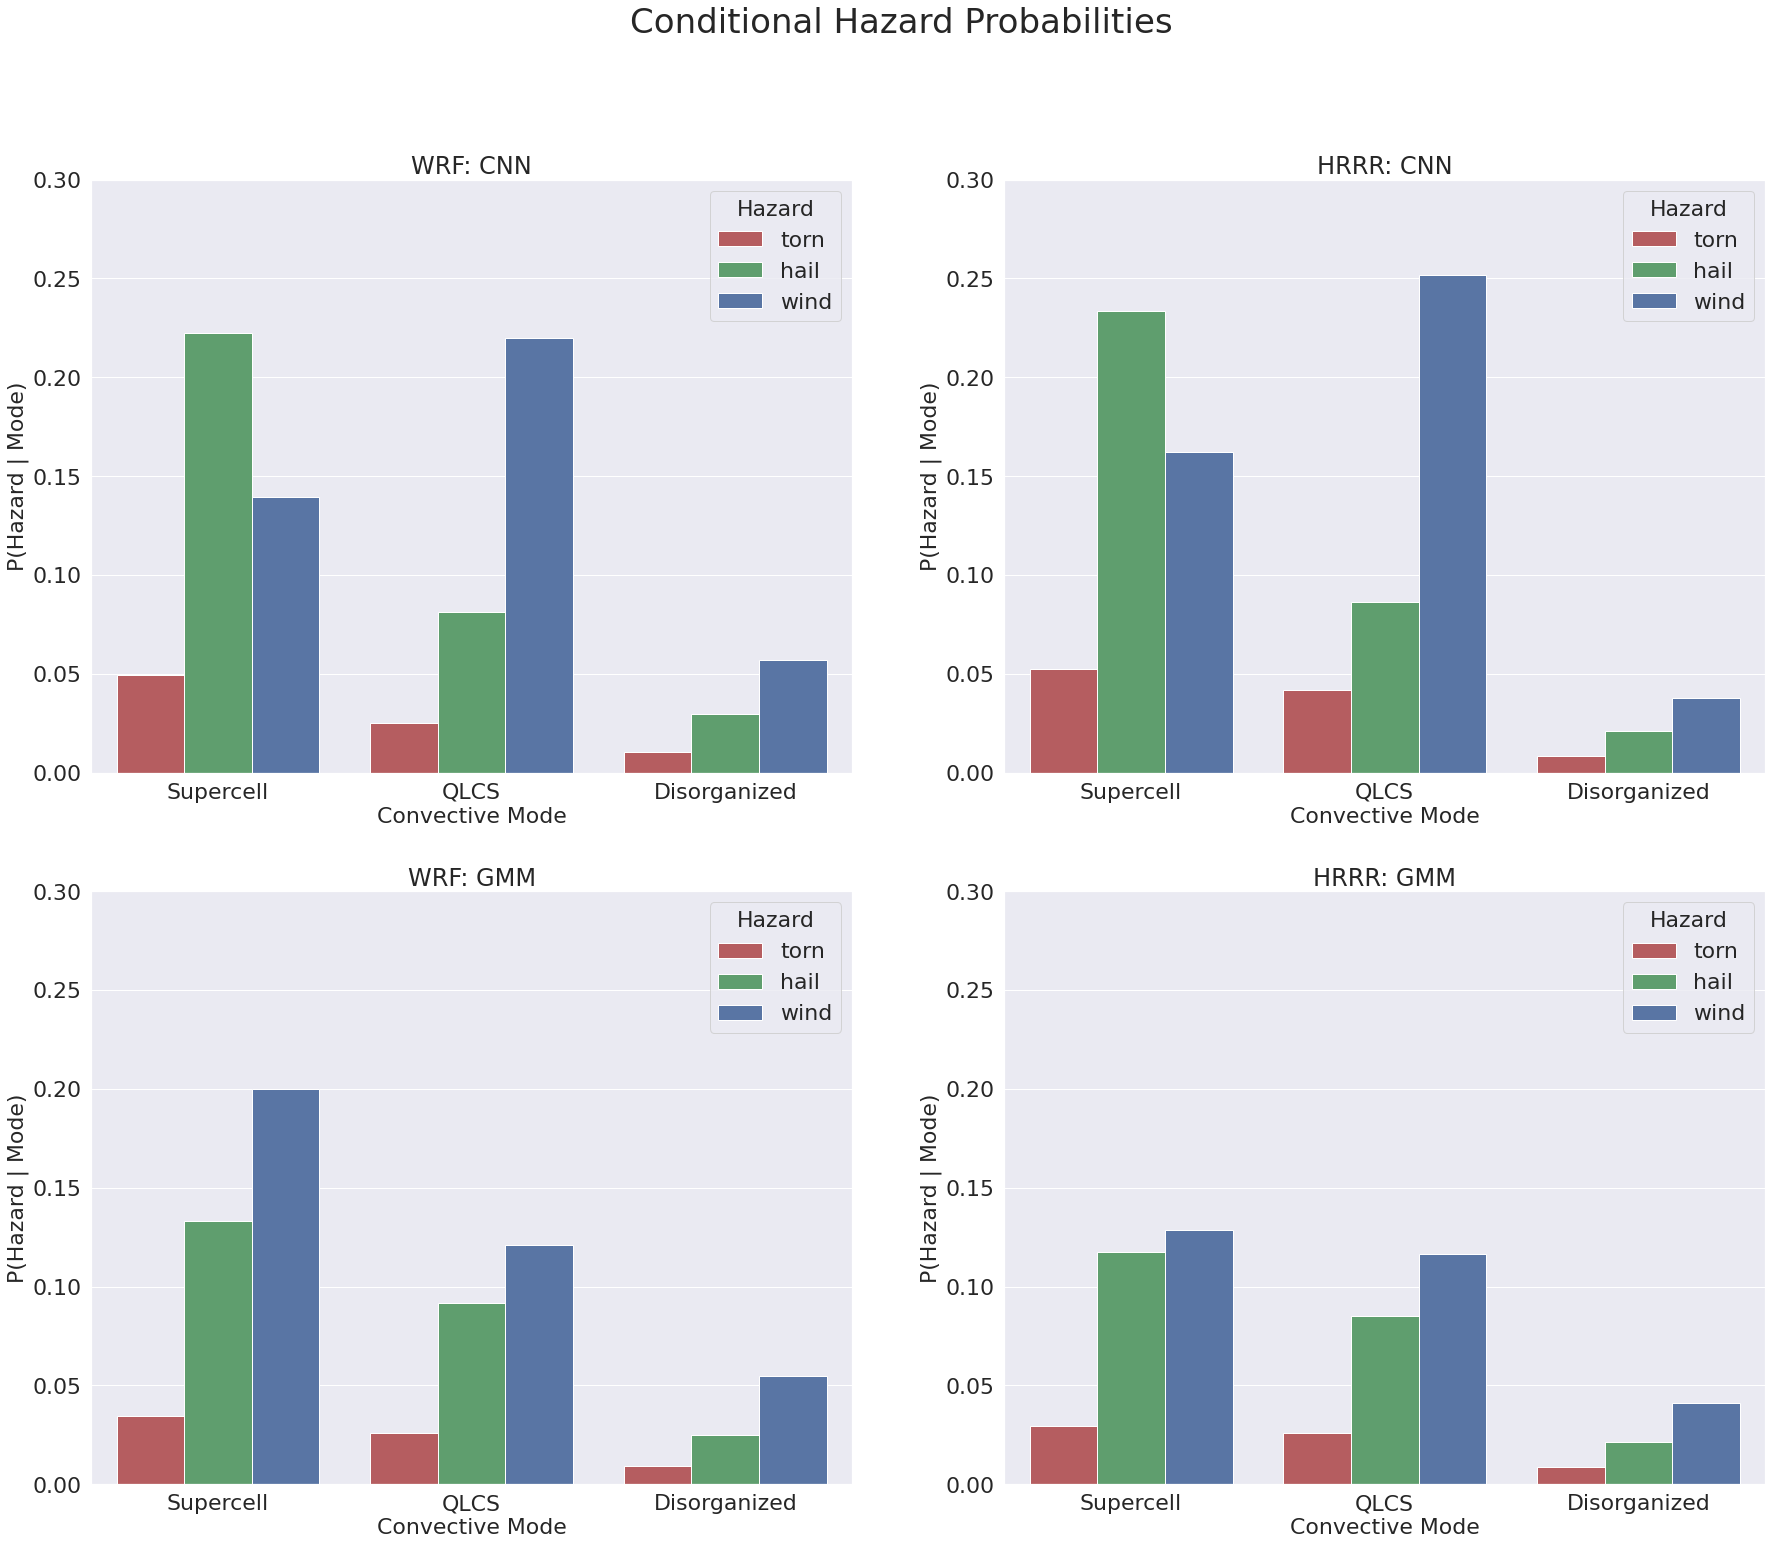

In [30]:
all_data = [wrf_cnn, hrrr_cnn, wrf_gmm, hrrr_gmm]
titles = ['WRF: CNN', 'HRRR: CNN', 'WRF: GMM', 'HRRR: GMM']
fig, axes = plt.subplots(2,2, figsize=(30,24))
for i, ax in enumerate(axes.ravel()):
    p = sns.barplot(hue='Hazard', y='Cond Prob', x='Storm Mode', data=all_data[i], palette=['r','g','b'], ax=ax)
    ax.set_ylim(0, 0.30)
    ax.set_title(titles[i], fontsize=24)
    plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize='22')
    ax.set_ylabel('P(Hazard | Mode)', fontsize=22)
    ax.set_xlabel('Convective Mode', fontsize=22)
plt.suptitle('Conditional Hazard Probabilities', fontsize=34)
plt.savefig('/glade/work/cbecker/HWT_output/plots/HWT_Conditional_probs.png', dpi=300, bbox_inches='tight')

In [31]:
cp_HRRR = {}
n = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
hrrr_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_daily_rerun.nc')
hrrr_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_daily_rerun.nc')
for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        cp_HRRR[f'{mode}_{hazard}_CNN'] = []
        cp_HRRR[f'{mode}_{hazard}_GMM'] = []
        
        for i in range(len(n)-1):

            cp_HRRR[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, hrrr_cnn, hazard, mode, 2, n[i], n[i+1]))
            cp_HRRR[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, hrrr_gmm, hazard, mode, 2, n[i], n[i+1]))
            
del hrrr_cnn, hrrr_gmm

cp_WRF = {}
n = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]
wrf_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_CNN_daily_rerun.nc')
wrf_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_GMM_daily_rerun.nc')
for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        cp_WRF[f'{mode}_{hazard}_CNN'] = []
        cp_WRF[f'{mode}_{hazard}_GMM'] = []
        for i in range(len(n)-1):
    
            cp_WRF[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, wrf_cnn, hazard, mode, 2, n[i], n[i+1]))
            cp_WRF[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, wrf_gmm, hazard, mode, 2, n[i], n[i+1]))
            
for key in cp_HRRR.keys():
    for i in range(len(n)-1):
        if cp_HRRR[key][i] == 0:
            cp_HRRR[key][i] = np.nan
        if cp_WRF[key][i] == 0:
            cp_WRF[key][i] = np.nan

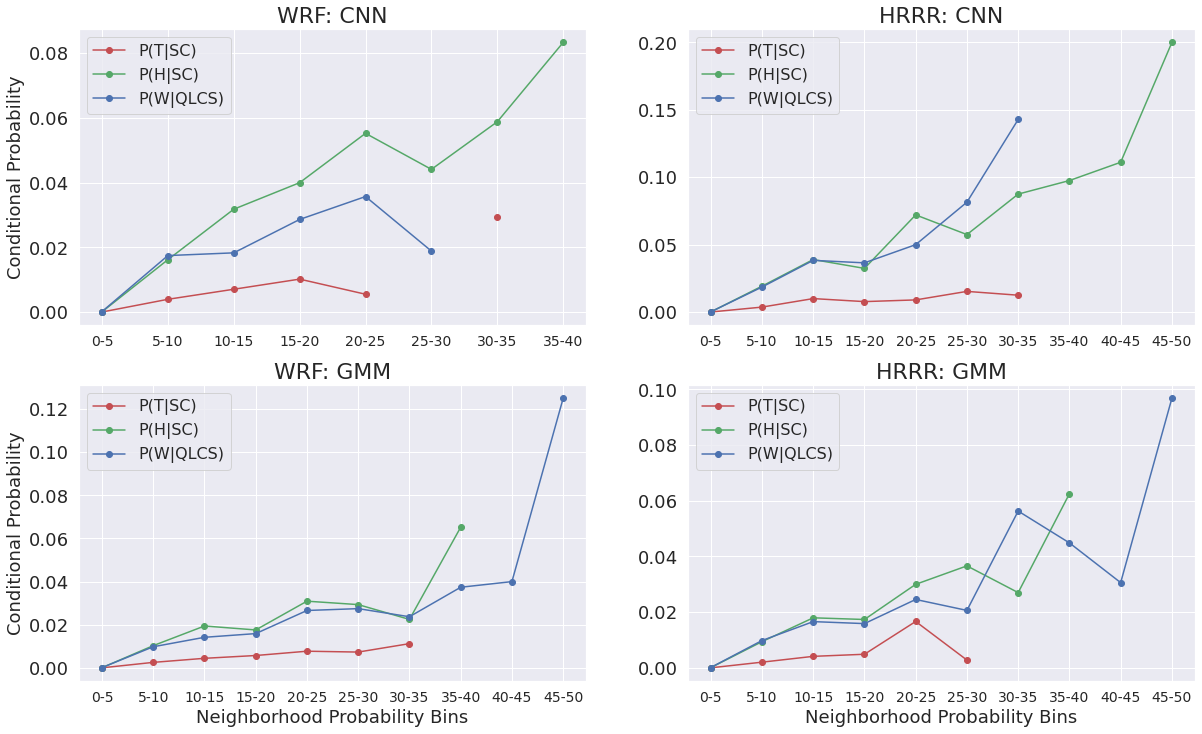

In [32]:
ltype = ['r-o', 'g-o', 'b-o']
ltype2 = ['r--o', 'g--o', 'b--o']
x_vals = ['0-5', '5-10' , '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50']
sns.set(font_scale = 2)


fig, axes = plt.subplots(2, 2, figsize=(20,12))
for i, ax in enumerate(axes.ravel()):
    if i == 0:
        ax.plot(x_vals, cp_WRF['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, cp_WRF['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, cp_WRF['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: CNN', fontsize=22)
        ax.set_ylabel('Conditional Probability', fontsize=18)

    elif i == 1:
        ax.plot(x_vals, cp_HRRR['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, cp_HRRR['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, cp_HRRR['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: CNN', fontsize=22)
    elif i == 2:
        ax.plot(x_vals, cp_WRF['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, cp_WRF['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, cp_WRF['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: GMM', fontsize=22)
        ax.set_xlabel('Neighborhood Probability Bins', fontsize=18)
        ax.set_ylabel('Conditional Probability', fontsize=18)
    elif i == 3:
        ax.plot(x_vals, cp_HRRR['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, cp_HRRR['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, cp_HRRR['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: GMM', fontsize=22)
        ax.set_xlabel('Neighborhood Probability Bins', fontsize=18)

    ax.legend(prop={'size': 16})
    ax.tick_params(axis='both', labelsize=18)
    ax.tick_params(axis='x', labelsize=14)
plt.savefig('/glade/work/cbecker/HWT_output/plots/HWT_Conditional_probs_neighborhoods_bins_5_daily.png', dpi=300, bbox_inches='tight')

In [33]:
ML_prob_HRRR = {}
n = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        ML_prob_HRRR[f'{mode}_{hazard}_CNN'] = []
        ML_prob_HRRR[f'{mode}_{hazard}_GMM'] = []
        for thresh in range(10, 100, 10):
            hrrr_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_daily_thresh_{thresh}.nc')
            hrrr_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_daily_thresh_{thresh}.nc')
            ML_prob_HRRR[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, hrrr_cnn, hazard, mode))
            ML_prob_HRRR[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, hrrr_gmm, hazard, mode))
            
del hrrr_cnn, hrrr_gmm

ML_prob_WRF = {}
for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        ML_prob_WRF[f'{mode}_{hazard}_CNN'] = []
        ML_prob_WRF[f'{mode}_{hazard}_GMM'] = []
        for thresh in range(10, 100, 10):
            wrf_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_CNN_daily_thresh_{thresh}.nc')
            wrf_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_GMM_daily_thresh_{thresh}.nc')
            ML_prob_WRF[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, wrf_cnn, hazard, mode))
            ML_prob_WRF[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, wrf_gmm, hazard, mode))
            
for key in ML_prob_HRRR.keys():
    for i in range(len(n)-2):
        if ML_prob_HRRR[key][i] == 0:
            ML_prob_HRRR[key][i] = np.nan
        if ML_prob_WRF[key][i] == 0:
            ML_prob_WRF[key][i] = np.nan

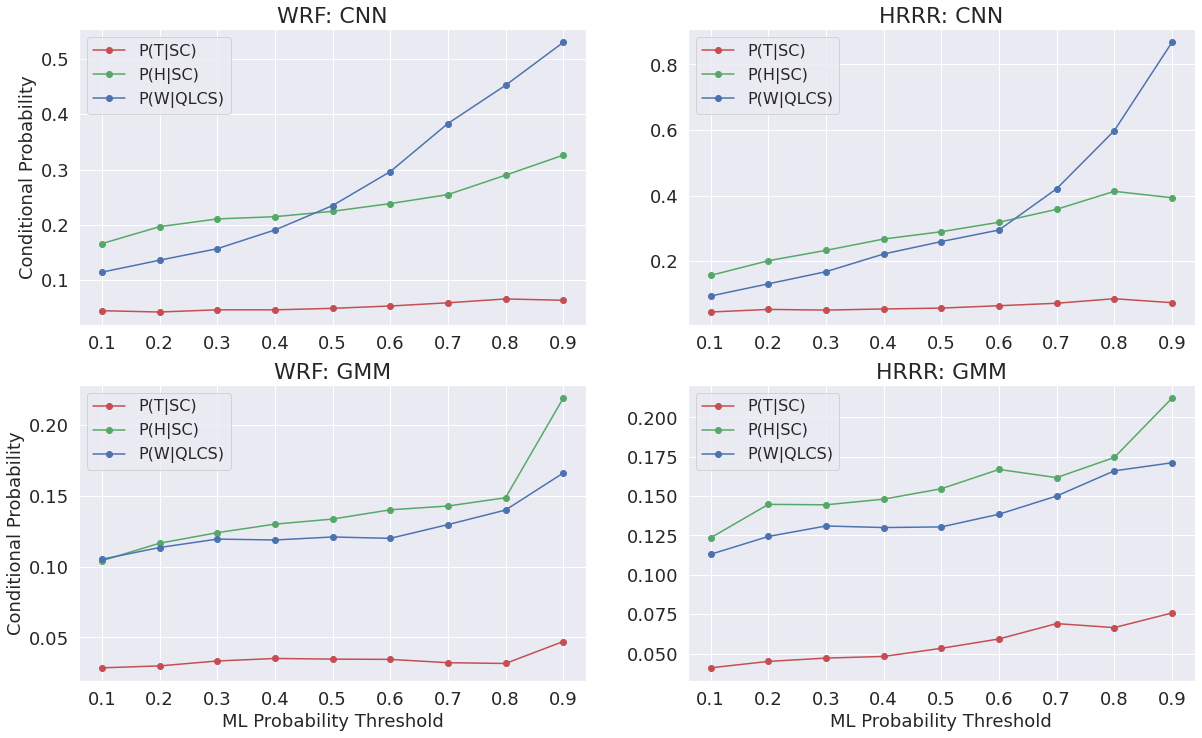

In [35]:
ltype = ['r-o', 'g-o', 'b-o']
ltype2 = ['r--o', 'g--o', 'b--o']
x_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

fig, axes = plt.subplots(2, 2, figsize=(20,12))
for i, ax in enumerate(axes.ravel()):
    if i == 0:
        ax.plot(x_vals, ML_prob_WRF['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, ML_prob_WRF['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals,ML_prob_WRF['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: CNN', fontsize=22)
        ax.set_ylabel('Conditional Probability', fontsize=18)

    elif i == 1:
        ax.plot(x_vals, ML_prob_HRRR['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, ML_prob_HRRR['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals,ML_prob_HRRR['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: CNN', fontsize=22)
    elif i == 2:
        ax.plot(x_vals, ML_prob_WRF['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, ML_prob_WRF['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, ML_prob_WRF['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: GMM', fontsize=22)
        ax.set_xlabel('ML Probability Threshold', fontsize=18)
        ax.set_ylabel('Conditional Probability', fontsize=18)
    elif i == 3:
        ax.plot(x_vals, ML_prob_HRRR['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, ML_prob_HRRR['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals,ML_prob_HRRR['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: GMM', fontsize=22)
        ax.set_xlabel('ML Probability Threshold', fontsize=18)
    ax.legend(prop={'size': 16})
    ax.tick_params(axis='both', labelsize=18)
plt.savefig('/glade/work/cbecker/HWT_output/plots/HWT_Conditional_probs_ML_thresholds.png', dpi=300, bbox_inches='tight')

In [36]:
n_prob_HRRR = {}
p = [0, 2, 5, 8, 11, 14, 17, 20]

for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        n_prob_HRRR[f'{mode}_{hazard}_CNN'] = []
        n_prob_HRRR[f'{mode}_{hazard}_GMM'] = []
        for n in p:
            hrrr_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_CNN_daily_neighProb_{n}.nc')
            hrrr_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_HRRR_GMM_daily_neighProb_{n}.nc')

            n_prob_HRRR[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, hrrr_cnn, hazard, mode, n))
            n_prob_HRRR[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, hrrr_gmm, hazard, mode, n))
            
del hrrr_cnn, hrrr_gmm

n_prob_WRF = {}
for mode in ['Supercell', 'QLCS', 'Disorganized']:
    for hazard in ['torn', 'hail', 'wind']:
        n_prob_WRF[f'{mode}_{hazard}_CNN'] = []
        n_prob_WRF[f'{mode}_{hazard}_GMM'] = []
        for n in p:
            wrf_cnn = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_CNN_daily_neighProb_{n}.nc')
            wrf_gmm = xr.open_dataset(f'/glade/scratch/cbecker/HWT_postproc/HWT_WRF_GMM_daily_neighProb_{n}.nc')
    
            n_prob_WRF[f'{mode}_{hazard}_CNN'].append(hazard_cond_prob(obs, wrf_cnn, hazard, mode, n))
            n_prob_WRF[f'{mode}_{hazard}_GMM'].append(hazard_cond_prob(obs, wrf_gmm, hazard, mode, n))

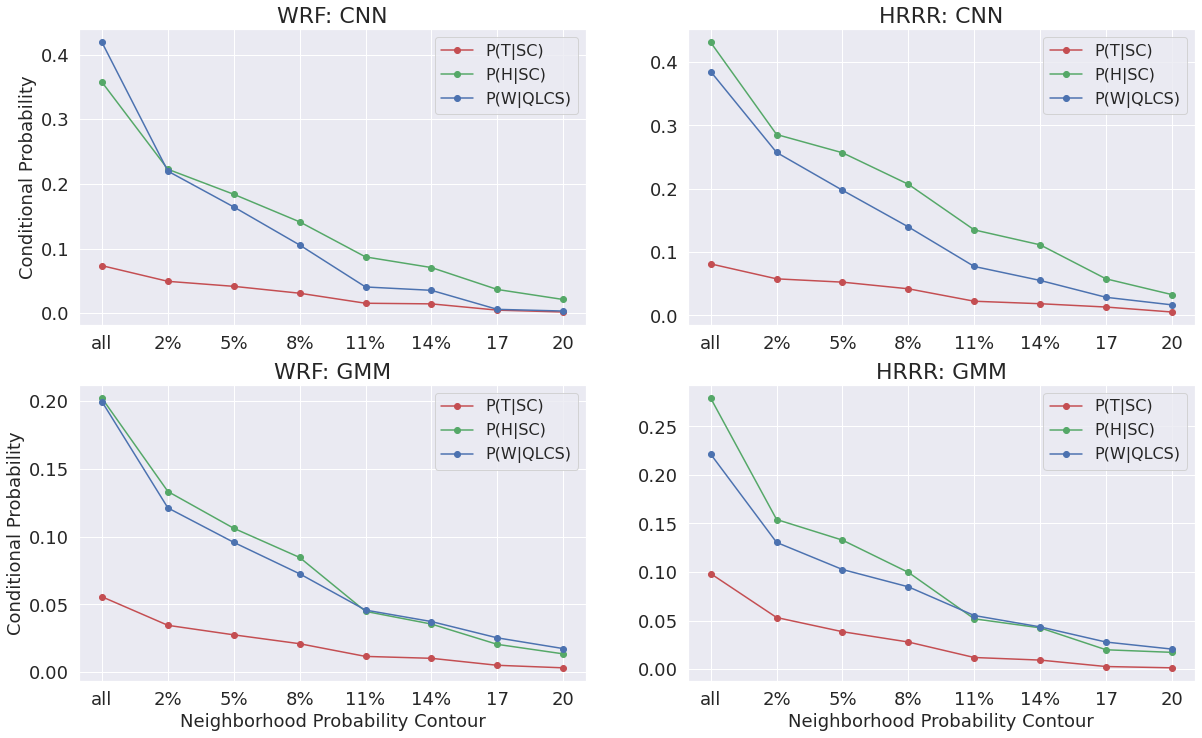

In [38]:
ltype = ['r-o', 'g-o', 'b-o']
ltype2 = ['r--o', 'g--o', 'b--o']
x_vals = ['all', '2%', '5%', '8%', '11%', '14%', 17, 20]

fig, axes = plt.subplots(2, 2, figsize=(20,12))
for i, ax in enumerate(axes.ravel()):
    if i == 0:
        ax.plot(x_vals, n_prob_WRF['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, n_prob_WRF['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, n_prob_WRF['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: CNN', fontsize=22)
        ax.set_ylabel('Conditional Probability', fontsize=18)

    elif i == 1:
        ax.plot(x_vals, n_prob_HRRR['Supercell_torn_CNN'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, n_prob_HRRR['Supercell_hail_CNN'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, n_prob_HRRR['QLCS_wind_CNN'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: CNN', fontsize=22)
    elif i == 2:
        ax.plot(x_vals, n_prob_WRF['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, n_prob_WRF['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, n_prob_WRF['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('WRF: GMM', fontsize=22)
        ax.set_xlabel('Neighborhood Probability Contour', fontsize=18)
        ax.set_ylabel('Conditional Probability', fontsize=18)
    elif i == 3:
        ax.plot(x_vals, n_prob_HRRR['Supercell_torn_GMM'], ltype[0], label='P(T|SC)')
        ax.plot(x_vals, n_prob_HRRR['Supercell_hail_GMM'], ltype[1], label='P(H|SC)')
        ax.plot(x_vals, n_prob_HRRR['QLCS_wind_GMM'], ltype[2], label='P(W|QLCS)')
        ax.set_title('HRRR: GMM', fontsize=22)
        ax.set_xlabel('Neighborhood Probability Contour', fontsize=18)
    ax.legend(prop={'size': 16})
    ax.tick_params(axis='both', labelsize=18)
plt.savefig('/glade/work/cbecker/HWT_output/plots/HWT_Conditional_probs_neighborhood_contour.png', dpi=300, bbox_inches='tight')